<a href="https://colab.research.google.com/github/adammuhtar/sierra/blob/main/notebooks/sierra-llama3-langgraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SIERRA ⛰️ with Llama 3 🦙 and LangGraph 🦜🕸️: Liquidity Risk Management AI Team 🦾**

---

*- by Adam Muhtar*

This notebook details steps to run an end-to-end Agentic RAG framework, i.e. SIERRA (Semantic Information Encoding, Retrieval, and Reasoning Agents), powered by [Sentence Transformers](https://sbert.net), [LangGraph](https://python.langchain.com/docs/langgraph/), [Llama 3](https://llama.meta.com/llama3/) model, and [Groq](https://groq.com) cloud servers.

Taking on the task of creating a team of AI agents to support a liquidity risk management team, we designate various 'sub-teams' based on the different aspects of liquidity risks, heavily inspired by [real world liquidity risk management practices](https://www.bankofengland.co.uk/prudential-regulation/publication/2018/pillar-2-liquidity):
* Cashflow mismatch risk
* Franchise viability risk
* Intraday liquidity risk

Each sub-team follows a general workflow to address specific liquidity risk concerns:

1. **Topic Generation:** We utilize a Large Language Model (LLM) to generate a series of targeted topics related to the user's question. These topics guide our information retrieval pipeline.
   
2. **Information Retrieval:** An ensemble retriever (combining semantic and lexical search) processes the synthetic queries generated in the first step. The results are then fed into an LLM contextual compressor to filter out irrelevant information.

3. **Report Generation:** Based on the filtered and relevant information retrieved, we generate a concise report to answer the user's question.

4. **Review for Accuracy:** A dedicated LLM agent reviews the report against the retrieved information to ensure factual accuracy and prevent model hallucination. If inaccuracies are detected, the agent provides detailed comments highlighting these issues.

5. **Report Rewriting:** A report rewriter considers both the original report and the reviewer agent's comments to generate an amended report. This process of review and rewriting repeats *n* times, as defined by the state machine.

By following this structured workflow, we ensure that the final output is not only accurate but also comprehensive, addressing the various nuances of liquidity risk management. The combination of advanced LLMs and robust retrieval mechanisms guarantees a high-quality, reliable framework suitable for complex, real-world applications.

## **Table of Contents**

* [1. Notebook setup](#section-1)
* [2. Download corpus and generate vector database](#section-2)
* [3. Define state machine and nodes](#section-3)
  * [3.1 Define nodes, edge connections, and graph for cashflow mismatch risk team](#section-3-1)
  * [3.2 Define nodes, edge connections, and graph for franchise viability risk team](#section-3-2)
  * [3.3 Define nodes, edge connections, and graph for intraday liquidity risk team](#section-3-3)
* [4. Define inter-agent team edges and graph](#section-4)
  * [4.1 Simplified overview of the graph](#section-4-1)
  * [4.2 Complete overview of the graph](#section-4-2)

---

## 1. Notebook Setup <a id="section-1"></a>

This notebook uses [Python 3.11.9](https://www.python.org/downloads/release/python-3119/). In principle, this notebook could also be run using [Google Colab](https://colab.research.google.com/) - Google's implementation of [Jupyter Notebooks](https://jupyter.org/). This notebook will require the following package(s) to be installed:
* `langchain`
* `langchain-community`
* `langchain-groq`
* `langgraph`
* `pygraphviz`
* `pymupdf`
* `python-dotenv`
* `sentence-transformers`
* `torch`
* `tqdm`

Running this Colab notebook will require hardware accelerators to access higher RAM runtimes to generate embeddings in section 2; this instance runs on the Tesla T4 GPU (16 GB GDDR6 @ 320 GB/s) provided for free by Google.

Additionally, we will be using the [Llama-3-70B](https://llama.meta.com/llama3/) model hosted on [Groq](https://groq.com) servers as the AI agents. We store our Groq API key in Colab's Secrets tab, accessible under the name "Groq-API".

In [1]:
# If running on Google Colab, check IP address if there are restrictions running non-local servers
!curl ipinfo.io

{
  "ip": "34.83.174.59",
  "hostname": "59.174.83.34.bc.googleusercontent.com",
  "city": "The Dalles",
  "region": "Oregon",
  "country": "US",
  "loc": "45.5946,-121.1787",
  "org": "AS396982 Google LLC",
  "postal": "97058",
  "timezone": "America/Los_Angeles",
  "readme": "https://ipinfo.io/missingauth"
}

In [2]:
# Query GPU device status/details if running on Google Colab
!nvidia-smi

Thu Jul  4 14:05:52 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# Install dependencies if running on Google Colab
!pip install --quiet --upgrade faiss-cpu langchain langchain-community langchain-groq langgraph pymupdf sentence_transformers torch tqdm

In [ ]:
# Standard library imports
import logging
from pathlib import Path
from pprint import pprint
import re
import requests
from typing import Dict, List, Literal, TypedDict, Union
from urllib.parse import urlparse
import uuid

# Third party imports
from dotenv import dotenv_values # If run locally, store API keys in .env file
# from google.colab import userdata # If running on Google Colab, store API keys in user secrets
from IPython.display import Image, display
from langchain.embeddings import HuggingFaceBgeEmbeddings
from langchain.retrievers import BM25Retriever, EnsembleRetriever, ContextualCompressionRetriever
from langchain.retrievers.document_compressors import LLMChainExtractor
from langchain.vectorstores import FAISS
from langchain.schema import Document
from langchain.prompts import PromptTemplate
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, ChatMessage
from langchain_core.output_parsers import JsonOutputParser, ListOutputParser, StrOutputParser
from langchain_groq import ChatGroq
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import StateGraph, END
from langgraph.graph.message import AnyMessage
import pymupdf
from sentence_transformers import SentenceTransformer, util
import torch
from tqdm import tqdm

# Configure logging
logging.basicConfig(
    level=logging.WARNING, format="%(asctime)s - %(name)s - %(levelname)s - %(message)s"
)

---

## 2. Download corpus and generate vector database <a id="section-2"></a>

This notebook makes use of several publicly available Pillar 3 reports from the following financial institutions:
* [Barclays](https://home.barclays/investor-relations/)
* [Citigroup](https://www.citigroup.com/global/investors)
* [Goldman Sachs](https://www.goldmansachs.com/investor-relations/)
* [JPMorgan Chase & Co](https://www.jpmorganchase.com/ir)
* [Santander](https://www.santander.com/en/shareholders-and-investors)

First, we create a function to enable bulk file downloads from URLs, stored in the following format

In [ ]:
# Store URLs as a list of dictionaries, with firm name as key and URL list as value
pillar_3_urls = [
    {
        "Barclays": [
            "https://home.barclays/content/dam/home-barclays/documents/investor-relations/reports-and-events/annual-reports/2023/Barclays-PLC-Pillar-3-Report-2023.pdf",
            "https://home.barclays/content/dam/home-barclays/documents/investor-relations/reports-and-events/annual-reports/2022/Pillar-3/Barclays-PLC-Pillar-3-Report-2022.pdf",
            "https://home.barclays/content/dam/home-barclays/documents/investor-relations/reports-and-events/annual-reports/2021/Barclays-PLC-Pillar-3-Report-2021.pdf",
            "https://home.barclays/content/dam/home-barclays/documents/investor-relations/reports-and-events/annual-reports/2020/Barclays%20PLC%20Pillar%203%20Report%202020.pdf"
        ]
    },{
        "Citigroup": [
            "https://www.citigroup.com/rcs/citigpa/storage/public/b3p3dq4231231.pdf",
            "https://www.citigroup.com/rcs/citigpa/storage/public/b3p3d221231.pdf",
            "https://www.citigroup.com/rcs/citigpa/akpublic/storage/public/b3p3d211231.pdf",
            "https://www.citigroup.com/rcs/citigpa/akpublic/storage/public/b3p3d201231.pdf"
        ]
    },
    {
        "Goldman-Sachs": [
            "https://www.goldmansachs.com/disclosures/gsguk-q3-2023-pillar-3.pdf",
            "https://www.goldmansachs.com/disclosures/gsguk-q4-2022-pillar-3.pdf",
            "https://www.goldmansachs.com/disclosures/gsguk-q4-2021-pillar-3.pdf",
            "https://www.goldmansachs.com/disclosures/gsguk-q4-2020-pillar-3.pdf"
        ]
    },
    {
        "JPMorgan": [
            "https://jpmorganchaseco.gcs-web.com/static-files/91be4bd7-30e3-4770-981a-58c3fb1f3265",
            "https://jpmorganchaseco.gcs-web.com/static-files/211f3263-1405-4e12-9a5d-336848f266aa",
            "https://jpmorganchaseco.gcs-web.com/static-files/557ed4c1-feaa-49e5-bdc5-8ae4cbc3dd4a",
            "https://jpmorganchaseco.gcs-web.com/static-files/17b49af2-ee6c-43dd-b856-ef47fe4b4805"
        ]
    },
    {
        "Santander": [
            "https://www.santander.com/content/dam/santander-com/en/documentos/informe-con-relevancia-prudencial/2023/irp-2023-irp-2023-en.pdf",
            "https://www.santander.com/content/dam/santander-com/en/documentos/informe-con-relevancia-prudencial/2022/irp-2022-irp-2022-en.pdf",
            "https://www.santander.com/content/dam/santander-com/en/documentos/informe-con-relevancia-prudencial/2021/irp-2021-irp-2021-en.pdf",
            "https://www.santander.com/content/dam/santander-com/en/documentos/informe-con-relevancia-prudencial/2020/irp-2020-irp-2020-en.pdf"
        ]
    }
]

In [ ]:
# Function to download files from a URLs list
def download_files(urls: List[Dict[str, list]], folder_path: Path) -> None:
    """
    Downloads a list of files from the specified URLs into a given folder.

    Args:
        * urls (`List[str]`): URLs of the files to download.
        * folder_path (`Path`): The Path object for the folder where the files
            will be saved.

    Creates a folder if it doesn't exist and downloads each file from the list into it.
    """
    # Create the folder if it doesn't exist
    folder_path.mkdir(parents=True, exist_ok=True)

    # Loop through the list of files and download each one
    for company in urls:
        for url in tqdm(
            iterable=list(company.values())[0],
            desc=f"Downloading files from {str(list(company.keys())[0])}",
            unit="file",
            total=len(list(company.values())[0])
        ):
            try:
                response = requests.get(url)
                response.raise_for_status()  # Raises HTTPError if the HTTP request returned an unsuccessful status code

                # Create a folder for company if it doesn't exist
                company_name = str(list(company.keys())[0])
                company_folder_path = folder_path / company_name
                company_folder_path.mkdir(parents=True, exist_ok=True)

                # Extract the file name from the URL
                file_name = Path(urlparse(url).path).name
                if not file_name.endswith(".pdf"):
                    file_name += ".pdf"

                # Write the file to the specified folder
                if (company_folder_path / file_name).exists():
                    logging.info(f"{file_name} already exists in {company_name} folder.")
                    continue
                else:
                    with open(company_folder_path / file_name, "wb") as file:
                        file.write(response.content)

            except requests.HTTPError as e:
                print(f"HTTP Error occurred: {e}")
            except Exception as e:
                print(f"An error occurred: {e}")

# Define the path where the documents will be saved and download the files
doc_dir = Path.cwd() / "pillar_3_reports"
download_files(urls=pillar_3_urls, folder_path=doc_dir)

In [ ]:
# List all documents available
pdf_files = []
for firm in pillar_3_urls:
    for firm_name, urls in firm.items():
        docs_dir = Path.cwd().parent / "data" / firm_name   # Change paths accordingly
        temp = list(docs_dir.rglob("*.pdf"))    # Store all PDFs paths as a list
        temp_dict = {firm_name: temp}
        pdf_files.append(temp_dict)
        print(f"Documents available for {firm_name}:")
        for i, pdf in enumerate(temp, start=1):
            print(f"{i}: {pdf.stem}")
        print("-" * 80)

Documents available for Barclays:
1: Barclays-PLC-Pillar-3-Report-2023
2: Barclays-PLC-Pillar-3-Report-2022
3: Barclays-PLC-Pillar-3-Report-2021
4: Barclays%20PLC%20Pillar%203%20Report%202020
--------------------------------------------------------------------------------
Documents available for Citigroup:
1: b3p3d221231
2: b3p3d211231
3: b3p3d201231
4: b3p3dq4231231
--------------------------------------------------------------------------------
Documents available for Goldman-Sachs:
1: gsguk-q4-2021-pillar-3
2: gsguk-q4-2020-pillar-3
3: gsguk-q4-2022-pillar-3
4: gsguk-q3-2023-pillar-3
--------------------------------------------------------------------------------
Documents available for JPMorgan:
1: 17b49af2-ee6c-43dd-b856-ef47fe4b4805
2: 91be4bd7-30e3-4770-981a-58c3fb1f3265
3: 557ed4c1-feaa-49e5-bdc5-8ae4cbc3dd4a
4: 211f3263-1405-4e12-9a5d-336848f266aa
--------------------------------------------------------------------------------
Documents available for Santander:
1: irp-2023-irp

In [ ]:
# Setup the LLM
try:
    # Load config files
    SHARED_ENV_PATH = Path.cwd().parent / ".config" / ".env.shared"
    SECRET_ENV_PATH = Path.cwd().parent / ".config" / ".env.secret"
    config = {
        **dotenv_values(str(SHARED_ENV_PATH)),
        **dotenv_values(str(SECRET_ENV_PATH))
    }

    # Instantiate LLM
    llm = ChatGroq(
        model=config["GROQ_LLAMA_3_70B_MODEL"],
        temperature=0,
        groq_api_key=config["GROQ_API_KEY"]
    )
    logging.info("Groq API credentials successfully loaded")
except FileNotFoundError:
    logging.error(f"Colab secrets not found")
    raise
except KeyError:
    logging.error(f"API credentials in Colab secrets not formatted correctly")
    raise
except Exception as e:
    logging.error(f"An error occurred while loading the API key: {e}")
    raise

# Setup encoder for semantic search
device = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_built()
    else "cpu"
)
bge_embeddings = HuggingFaceBgeEmbeddings(
    model_name="BAAI/bge-large-en-v1.5",
    model_kwargs={"device": device},
    encode_kwargs={"normalize_embeddings": True}
)

# Extract text from PDFs
doc_db = []
for pdf in pdf_files:
    for firm in pdf:
        doc_db.append({firm: []})
        for pdf_path in pdf[firm]:
            docs = []
            docs.extend(PyMuPDFLoader(str(pdf_path)).load())
            doc_db[-1][firm].extend(docs)

# Setting up an ensemble retriever with contextual compression
retriever_db = []
for i in tqdm(
    iterable=range(len(doc_db)),
    desc="Setting up retrievers",
    unit="corpus",
    total=len(doc_db)
):
    for firm, docs in doc_db[i].items():
        # Setting up an ensemble retriever with BM25 and FAISS
        faiss_retriever = FAISS.from_documents(
            documents=docs, embedding=bge_embeddings
        ).as_retriever(search_kwargs={"k": 10})
        bm25_retriever = BM25Retriever.from_documents(docs)
        bm25_retriever.k = 10
        ensemble_retriever = EnsembleRetriever(
            retrievers=[faiss_retriever, bm25_retriever], weights=[0.8, 0.2]
        )

        # Setting up LLM-powered contextual compression pipeline
        extractor = LLMChainExtractor.from_llm(llm)
        cc_retriever = ContextualCompressionRetriever(
            base_compressor=extractor, base_retriever=ensemble_retriever
        )
        retriever_db.append({firm: cc_retriever})

Setting up retrievers: 100%|██████████| 5/5 [06:47<00:00, 81.58s/corpus] 


In [ ]:
# Print retriever database structure
retriever_db

[{'Barclays': ContextualCompressionRetriever(base_compressor=LLMChainExtractor(llm_chain=LLMChain(prompt=PromptTemplate(input_variables=['context', 'question'], output_parser=NoOutputParser(), template='Given the following question and context, extract any part of the context *AS IS* that is relevant to answer the question. If none of the context is relevant return NO_OUTPUT. \n\nRemember, *DO NOT* edit the extracted parts of the context.\n\n> Question: {question}\n> Context:\n>>>\n{context}\n>>>\nExtracted relevant parts:'), llm=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x31978ab90>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x3197750d0>, model_name='llama3-70b-8192', temperature=1e-08, groq_api_key=SecretStr('**********'))), get_input=<function default_get_input at 0x105af31a0>), base_retriever=EnsembleRetriever(retrievers=[VectorStoreRetriever(tags=['FAISS', 'HuggingFaceBgeEmbeddings'], vectorstore=<langchain_community.vect

---

## 3. Define agent class and nodes <a id="section-3"></a>

Taking on the 'persona' of a liquidity risk management team, we designate various 'subteams' based on the various aspects of liquidity risks:
* [Cashflow mismatch risk](#section-3-1)
* [Franchise viability risk](#section-3-2)
* [Intraday liquidity risk](#section-3-3)

The state machine tracking the outputs of various agents are shown in the `AgentState` class below

In [ ]:
class AgentState(TypedDict):
    """
    Instantiates a state machine to track the outputs of various agents.

    Attributes:
        * user_input (`str`): Query provided by the user.
        * cfmr_queries (`dict`): Supplementary synthetic queries generated based
            on the user's query for the cashflow mismatch team.
        * cfmr_retrieved_info (`list`): Relevant information retrieved from the
            vector database for the cashflow mismatch team.
        * cfmr_report (`str`): LLM-generated report based on retrieved information
            for the cashflow mismatch team.
        * cfmr_review (`dict`): LLM review of the cashflow mismatch team's
            LLM-generated report.
        * cfmr_revision_count (`int`): Revision counter of the cashflow mismatch
            team's LLM-generated report.
        * fvr_queries (`dict`): Supplementary synthetic queries generated based
            on the user's query for the franchise viability risk team.
        * fvr_retrieved_info (`list`): Relevant information retrieved from the
            vector database for the franchise viability risk team.
        * fvr_report (`str`): LLM-generated report based on retrieved information
            for the franchise viability risk team.
        * fvr_review (`dict`): LLM review of the franchise viability risk team's
            LLM-generated report.
        * fvr_revision_count (`int`): Revision counter of the franchise viability
            risk team's LLM-generated report.
        * ilr_queries (`dict`): Supplementary synthetic queries generated based
            on the user's query for the intraday liquidity risk team.
        * ilr_retrieved_info (`list`): Relevant information retrieved from the
            vector database for the intraday liquidity risk team.
        * ilr_report (`str`): LLM-generated report based on retrieved information
            for the intraday liquidity risk team.
        * ilr_revision_count (`int`): Revision counter of the intraday liquidity
            risk team's LLM-generated report.
        * compiled_report (`str`): Compiled report of the LLM-generated reports.
        * teams_activated (`list`): List of activated teams.
        * teams_completed (`list`): List of completed teams.
    """
    user_input: str
    cfmr_queries : dict = {}
    cfmr_retrieved_info: list = []
    cfmr_report: str = ""
    cfmr_review: dict = {}
    cfmr_revision_count: int = 1
    fvr_queries : dict = {}
    fvr_retrieved_info: list = []
    fvr_report: str = ""
    fvr_review: dict = {}
    fvr_revision_count: int = 1
    ilr_queries : dict = {}
    ilr_retrieved_info: list = []
    ilr_report: str = ""
    ilr_review: dict = {}
    ilr_revision_count: int = 1
    compiled_report: str = ""
    teams_activated: list = []
    teams_completed: list = []

### 3.1 Define nodes, edge connections, and graph for cashflow mismatch risk team<a id="section-3-1"></a>

The general workflow for each team undertakes is as follows:
1. First, we utilise an LLM to generate a series of targetted topics related to the user's question to run our information retrieval pipeline.
2. We then run an ensemble retriever (semantic + lexical search) on the synthetic queries generated, which are then fed into an LLM contextual compressor to filter out irrelevant information.
3. Based on the retrieved information, we generate a concise report to answer the user's question.
4. A dedicated LLM agent will review the report against the retrieved information, to ensure factual accuracy and prevent model hallucination. If inaccuracies are detected, the agent will provide detailed comments on what those inaccuracies are.
5. A report rewriter will take into consideration both the original report and the reviewer agent's comments, and generate an amended report. This process of review-rewrite will repeat *n* times, defined by the state machine.

In [ ]:
def cfmr_query_generator_node(state: AgentState):
    user_input = state["user_input"]
    prompt = f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|> \
    Based on the user's prompt about cashflow mismatch risk, extract the relevant \
    information to run a search. The extracted information can be structured as \
    keywords to search against or restructured queries. DO NOT change the underlying \
    meaning of the user's question. DO NOT miss out any abbreviations or acronyms, \
    be sure to include both the full term and the abbreviation in the query.

    For context, cashflow mismatch risk revolves around the risk that a firm has \
    insufficient liquidity from high quality liquid assets (HQLA) and other \
    liquidity inflows to cover liquidity outflows on a daily basis, e.g. measure \
    of a firm's cumulative liquidity position at the end of a 30 day period, i.e. \
    liquidity coverage ratio (LCR). The cashflow mismatch risk framework focuses \
    on specific sources of risk, such as 'low point risk,' where a firm's peak \
    liquidity need within the 30-day window may exceed its day 30 requirement, \
    monetisation risks of HQLA due to market limitations, 'cliff risk' from maturity \
    mismatches beyond the 30-day horizon, and FX mismatch risks in accessing \
    foreign exchange markets during stress periods​.

    Return the decision in JSON format with the key being the name of the firm in \
    question e.g. 'Barclays' followed by the list of queries relevant to topic of \
    cashflow mismatch risk. The list of queries themselves do not need to repeat \
    the firm name. Each firm-query pair should be a dictionary. Limit your \
    queries to 3.
    <|eot_id|><|start_header_id|>user<|end_header_id|>
    QUERY: {user_input}
    <|eot_id|><|start_header_id|>assistant<|end_header_id|>"""
    cfmr_retrieval_prompt = PromptTemplate(
        template=re.sub(" +", " ", prompt.strip()),
        input_variables=user_input
    )
    cfmr_retrieval_router = cfmr_retrieval_prompt | llm | JsonOutputParser()
    return {"cfmr_queries": cfmr_retrieval_router.invoke({"user_input": user_input})}


query = "How much has Barclays LCR dropped between 2020 to 2023"
test_state = AgentState(user_input=query)
query_gen = cfmr_query_generator_node(test_state)
pprint(query_gen, indent=1)

{'cfmr_queries': {'Barclays': ['Liquidity Coverage Ratio (LCR) Barclays '
                               '2020-2023',
                               'Barclays cash flow mismatch risk 2020 vs 2023',
                               "Change in Barclays' LCR from 2020 to 2023"]}}


In [ ]:
def cfmr_hybrid_search_node(state: AgentState):
    retrieved_info = []
    for firm, queries in state["cfmr_queries"].items():
        retrieved_info.append({firm: []})
        for retriever in retriever_db:
            for firm_name, retr in retriever.items():
                if firm == firm_name:
                    for query in tqdm(
                        iterable=queries,
                        desc=f"Retrieving information from {firm}",
                        unit="query",
                        total=len(queries)
                    ):
                        temp = retr.invoke(query)
                        compressed_context = ""
                        for i, doc in enumerate(temp, start=1):
                            compressed_context += f"Source {i}: " + doc.metadata["title"] + "\n"
                            compressed_context += "Page: " + str(doc.metadata["page"]) + "\n"
                            compressed_context += "Content: " + doc.page_content + "\n\n"
                        retrieved_info[-1][firm].append(compressed_context)
                else:
                    logging.error(f"Retriever for {firm} not found.")
                    continue

    return {"cfmr_retrieved_info": retrieved_info}

# Test whether the retrieval node works
storage = []
for firm, queries in res["cfmr_queries"].items():
    storage.append({firm: []})
    for retriever in retriever_db:
        for firm_name, retr in retriever.items():
            if firm == firm_name:
                for query in tqdm(
                    iterable=queries,
                    desc=f"Retrieving information from {firm}",
                    unit="query",
                    total=len(queries)
                ):
                    temp = retr.invoke(query)
                    compressed_context = ""
                    for i, doc in enumerate(temp, start=1):
                        compressed_context += f"Source {i}: " + doc.metadata["title"] + "\n"
                        compressed_context += "Page: " + str(doc.metadata["page"]) + "\n"
                        compressed_context += "Content: " + doc.page_content + "\n\n"
                    storage[-1][firm].append(compressed_context)
            else:
                logging.error(f"Retriever for {firm} not found.")
                continue

Retrieving information from Barclays: 100%|██████████| 3/3 [07:30<00:00, 150.21s/query]


In [ ]:
def cfmr_report_writer_node(state: AgentState):
    user_input = state["user_input"]
    retrieved_info = state["cfmr_retrieved_info"]
    prompt = f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|> \
    Based on the user's prompt about cashflow mismatch risk and the retrieved \
    information, write a report that addresses the user's query. The report should \
    contain ONLY the relevant information extracted from the documents. DO NOT \
    include any additional information that is not directly related to the user's \
    query. The report should be concise and to the point. Always cite where the \
    information was extracted from, use the source name and page number.

    For context, cashflow mismatch risk revolves around the risk that a firm has \
    insufficient liquidity from high quality liquid assets (HQLA) and other \
    liquidity inflows to cover liquidity outflows on a daily basis, e.g. measure \
    of a firm's cumulative liquidity position at the end of a 30 day period, i.e. \
    liquidity coverage ratio (LCR). The cashflow mismatch risk framework focuses \
    on specific sources of risk, such as 'low point risk,' where a firm's peak \
    liquidity need within the 30-day window may exceed its day 30 requirement, \
    monetisation risks of HQLA due to market limitations, 'cliff risk' from maturity \
    mismatches beyond the 30-day horizon, and FX mismatch risks in accessing \
    foreign exchange markets during stress periods​.
    <|eot_id|><|start_header_id|>user<|end_header_id|>
    QUERY: {user_input}
    CONTEXT: {retrieved_info}
    <|eot_id|><|start_header_id|>assistant<|end_header_id|>"""
    cfmr_report_writer_prompt = PromptTemplate(
        template=re.sub(" +", " ", prompt.strip()),
        input_variables=[user_input, retrieved_info]
    )
    cfmr_report_writer_router = cfmr_report_writer_prompt | llm | StrOutputParser()
    return {
        "cfmr_report": cfmr_report_writer_router.invoke(
            {"user_input": user_input, "retrieved_info": retrieved_info}
        )
    }

query = "How much has Barclays LCR changed between 2020 to 2023"
test_state = AgentState(
    user_input=query, cfmr_retrieved_info=storage[0]["Barclays"][0]
)
report = cfmr_report_writer_node(test_state)
print(report["cfmr_report"])

Report: Change in Barclays' Liquidity Coverage Ratio (LCR) between 2020 and 2023

According to the provided sources, the Liquidity Coverage Ratio (LCR) of Barclays has changed between 2020 and 2023 as follows:

* As of 31 December 2020, the Barclays Group LCR was 162% (Source 3, Page 40), with an average LCR of 167% for the 12 months to 31 December 2020 (Source 3, Page 40).
* As of 2023, the LCR was 161% (Source 1, Page 19; Source 6, Page 6).

Therefore, the LCR of Barclays has decreased by 1 percentage point between 2020 and 2023.

References:

* Source 1: Barclays PLC Pillar 3 Report 2023 YE, Page 19
* Source 3: Page 40
* Source 6: Barclays PLC Pillar 3 Report 2023 YE, Page 6


In [ ]:
def cfmr_report_reviewer_node(state: AgentState):
    report = state["cfmr_report"]
    retrieved_info = state["cfmr_retrieved_info"]
    prompt = f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|> \
    Based on the report about cashflow mismatch risk and the retrieved \
    information, check if the report uses the correct information from the retrieved \
    documents. If the report is accurate, return 'accurate'. If the report is \
    inaccurate, return 'inaccurate'. If the report is inaccurate, provide a \
    thorough explanation of what is incorrect. Be specific about the inaccuracies, \
    listing the correct information that should have been included. DO NOT make \
    up any information that was not in the retrieved documents.

    For context, cashflow mismatch risk revolves around the risk that a firm has \
    insufficient liquidity from high quality liquid assets (HQLA) and other \
    liquidity inflows to cover liquidity outflows on a daily basis, e.g. measure \
    of a firm's cumulative liquidity position at the end of a 30 day period, i.e. \
    liquidity coverage ratio (LCR). The cashflow mismatch risk framework focuses \
    on specific sources of risk, such as 'low point risk,' where a firm's peak \
    liquidity need within the 30-day window may exceed its day 30 requirement, \
    monetisation risks of HQLA due to market limitations, 'cliff risk' from maturity \
    mismatches beyond the 30-day horizon, and FX mismatch risks in accessing \
    foreign exchange markets during stress periods​.

    Return the decision in JSON format with the first JSON key being 'decision' \
    and values either 'accurate' or 'inaccurate', the second \
    JSON key being 'comments' and values being any explanations related to the \
    decision.
    <|eot_id|><|start_header_id|>user<|end_header_id|>
    REPORT: {report}
    CONTEXT: {retrieved_info}
    <|eot_id|><|start_header_id|>assistant<|end_header_id|>"""
    cfmr_report_reviewer_prompt = PromptTemplate(
        template=re.sub(" +", " ", prompt.strip()),
        input_variables=[report, retrieved_info]
    )
    cfmr_report_reviewer_router = cfmr_report_reviewer_prompt | llm | JsonOutputParser()
    return {
        "cfmr_review": cfmr_report_reviewer_router.invoke(
            {"report": report, "retrieved_info": retrieved_info}
        )
    }

test_state = AgentState(
    cfmr_retrieved_info=storage[0]["Barclays"][0], cfmr_report=report["cfmr_report"]
)
review = cfmr_report_reviewer_node(test_state)
pprint(review["cfmr_review"])

{'comments': "The report accurately states the change in Barclays' Liquidity "
             'Coverage Ratio (LCR) between 2020 and 2023. The report correctly '
             'cites the sources and provides the correct values for the LCR in '
             "2020 (162% and 167% average) and 2023 (161%). The report's "
             'conclusion that the LCR decreased by 1 percentage point between '
             '2020 and 2023 is also accurate.',
 'decision': 'accurate'}


In [ ]:
def cfmr_report_rewriter_node(state: AgentState):
    user_input = state["user_input"]
    report = state["cfmr_report"]
    retrieved_info = state["cfmr_retrieved_info"]
    comments = review["cfmr_review"]["comments"]
    prompt = f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|> \
    Based on the report written about {user_input}, the relevant information \
    retrieved, and the reviewer's comments about the report's accuracy, amend \
    the report by addressing those comments. provided write a report that addresses \
    the user's query. The report should contain ONLY the relevant information \
    extracted from the documents. DO NOT add any additional information that is \
    not relevant to the user's query. The report should be concise and to the point. \
    Always cite where the information was extracted from, use the source name and \
    page number.

    For context, cashflow mismatch risk revolves around the risk that a firm has \
    insufficient liquidity from high quality liquid assets (HQLA) and other \
    liquidity inflows to cover liquidity outflows on a daily basis, e.g. measure \
    of a firm's cumulative liquidity position at the end of a 30 day period, i.e. \
    liquidity coverage ratio (LCR). The cashflow mismatch risk framework focuses \
    on specific sources of risk, such as 'low point risk,' where a firm's peak \
    liquidity need within the 30-day window may exceed its day 30 requirement, \
    monetisation risks of HQLA due to market limitations, 'cliff risk' from maturity \
    mismatches beyond the 30-day horizon, and FX mismatch risks in accessing \
    foreign exchange markets during stress periods​.
    <|eot_id|><|start_header_id|>user<|end_header_id|>
    REPORT: {report}
    CONTEXT: {retrieved_info}
    COMMENTS: {comments}
    <|eot_id|><|start_header_id|>assistant<|end_header_id>"""
    cfmr_report_writer_prompt = PromptTemplate(
        template=re.sub(" +", " ", prompt.strip()),
        input_variables=[user_input, report, retrieved_info, comments]
    )
    cfmr_report_writer_router = cfmr_report_writer_prompt | llm | StrOutputParser()
    return {
        "cfmr_report": cfmr_report_writer_router.invoke(
            {
                "user_input": user_input,
                "report": report,
                "user_input": retrieved_info,
                "comments": comments
            }
        ),
        "cfmr_revision_count": state["cfmr_revision_count"] + 1
    }

query = """How much has Barclays LCR changed between 2020 to 2023"""
relevant_info = storage[0]["Barclays"][0]
test_state = AgentState(
    user_input=query,
    cfmr_retrieved_info=storage[0]["Barclays"][0],
    cfmr_report=report["cfmr_report"],
    cfmr_review=review["cfmr_review"],
    cfmr_revision_count=1
)
rewrite = cfmr_report_rewriter_node(test_state)
print(rewrite["cfmr_report"])

REPORT: Change in Barclays' Liquidity Coverage Ratio (LCR) between 2020 and 2023

According to the provided sources, the Liquidity Coverage Ratio (LCR) of Barclays has changed between 2020 and 2023 as follows:

* As of 31 December 2020, the Barclays Group LCR was 162% (Source 3, Page 40), with an average LCR of 167% for the 12 months to 31 December 2020 (Source 3, Page 40).
* As of 2023, the LCR was 161% (Source 1, Page 19; Source 6, Page 6).

Therefore, the LCR of Barclays has decreased by 1 percentage point between 2020 and 2023.

References:

* Source 1: Barclays PLC Pillar 3 Report 2023 YE, Page 19
* Source 3: Page 40
* Source 6: Barclays PLC Pillar 3 Report 2023 YE, Page 6


In [ ]:
def cfmr_report_rewriter_node(state: AgentState):
    user_input = state["user_input"]
    report = state["cfmr_report"]
    retrieved_info = state["cfmr_retrieved_info"]
    comments = review["cfmr_review"]["comments"]
    prompt = f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|> \
    Based on the report written about {user_input}, the relevant information \
    retrieved, and the reviewer's comments about the report's accuracy, amend \
    the report by addressing those comments. provided write a report that addresses \
    the user's query. The report should contain ONLY the relevant information \
    extracted from the documents. DO NOT add any additional information that is \
    not relevant to the user's query. The report should be concise and to the point. \
    Always cite where the information was extracted from, use the source name and \
    page number.

    For context, cashflow mismatch risk revolves around the risk that a firm has \
    insufficient liquidity from high quality liquid assets (HQLA) and other \
    liquidity inflows to cover liquidity outflows on a daily basis, e.g. measure \
    of a firm's cumulative liquidity position at the end of a 30 day period, i.e. \
    liquidity coverage ratio (LCR). The cashflow mismatch risk framework focuses \
    on specific sources of risk, such as 'low point risk,' where a firm's peak \
    liquidity need within the 30-day window may exceed its day 30 requirement, \
    monetisation risks of HQLA due to market limitations, 'cliff risk' from maturity \
    mismatches beyond the 30-day horizon, and FX mismatch risks in accessing \
    foreign exchange markets during stress periods​.
    <|eot_id|><|start_header_id|>user<|end_header_id|>
    REPORT: {report}
    CONTEXT: {retrieved_info}
    COMMENTS: {comments}
    <|eot_id|><|start_header_id|>assistant<|end_header_id>"""
    cfmr_report_writer_prompt = PromptTemplate(
        template=re.sub(" +", " ", prompt.strip()),
        input_variables=[user_input, report, retrieved_info, comments]
    )
    cfmr_report_writer_router = cfmr_report_writer_prompt | llm | StrOutputParser()
    return {
        "cfmr_report": cfmr_report_writer_router.invoke(
            {
                "user_input": user_input,
                "report": report,
                "user_input": retrieved_info,
                "comments": comments
            }
        ),
        "cfmr_report_revision_count": state["cfmr_report_revision_count"] + 1
    }

query = """How much has Barclays LCR changed between 2020 to 2023"""
relevant_info = storage[0]["Barclays"][0]
test_state = AgentState(
    user_input=query,
    cfmr_retrieved_info=storage[0]["Barclays"][0],
    cfmr_report=report["cfmr_report"],
    cfmr_review=review["cfmr_review"]
)
rewrite = cfmr_report_rewriter_node(test_state)
print(rewrite["cfmr_report"])

REPORT: Change in Barclays' Liquidity Coverage Ratio (LCR) between 2020 and 2023

According to the provided sources, the Liquidity Coverage Ratio (LCR) of Barclays has changed between 2020 and 2023 as follows:

* As of 31 December 2020, the Barclays Group LCR was 162% (Source 3, Page 40), with an average LCR of 167% for the 12 months to 31 December 2020 (Source 3, Page 40).
* As of 2023, the LCR was 161% (Source 1, Page 19; Source 6, Page 6).

Therefore, the LCR of Barclays has decreased by 1 percentage point between 2020 and 2023.

References:

* Source 1: Barclays PLC Pillar 3 Report 2023 YE, Page 19
* Source 3: Page 40
* Source 6: Barclays PLC Pillar 3 Report 2023 YE, Page 6


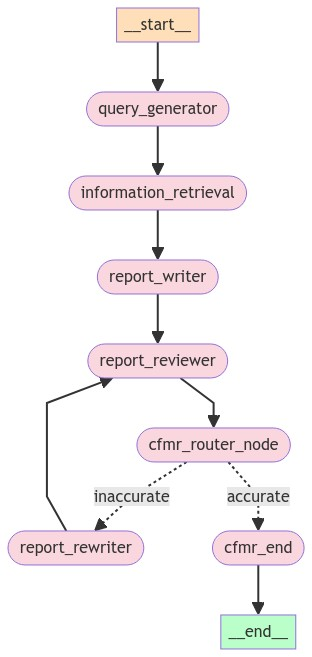

In [ ]:
# Define revision router node
def cfmr_router_node(state: AgentState):
    if state["cfmr_report_revision_count"] > 3:
        return "cfmr_end"
    else:
        return state["cfmr_review"]["decision"]

# Define nodes for the cashflow mismatch risk team
cfmr_state = StateGraph(AgentState)
cfmr_state.add_node(node="query_generator", action=cfmr_query_generator_node)
cfmr_state.add_node(node="information_retrieval", action=cfmr_hybrid_search_node)
cfmr_state.add_node(node="report_writer", action=cfmr_report_writer_node)
cfmr_state.add_node(node="report_reviewer", action=cfmr_report_reviewer_node)
cfmr_state.add_node(node="report_rewriter", action=cfmr_report_rewriter_node)
cfmr_state.add_node(
    node="cfmr_end",
    action=lambda state: {"final_report": state["content"]}
)

# Define edges for the cashflow mismatch risk team
cfmr_state.add_edge(start_key="query_generator", end_key="information_retrieval")
cfmr_state.add_edge(start_key="information_retrieval", end_key="report_writer")
cfmr_state.add_edge(start_key="report_writer", end_key="report_reviewer")
cfmr_state.add_conditional_edges(
    source="report_reviewer",
    path=cfmr_router_node,
    path_map={"inaccurate": "report_rewriter", "accurate": "cfmr_end"}
)
cfmr_state.add_edge(start_key="report_rewriter", end_key="report_reviewer")
cfmr_state.set_entry_point("query_generator")
cfmr_state.set_finish_point("cfmr_end")

# Compile and visualise the cashflow mismatch risk team state graph
app = cfmr_state.compile()
Image(app.get_graph(xray=1).draw_mermaid_png())

### 3.2 Define nodes, edge connections, and graph for franchise viability risk team<a id="section-3-2"></a>

We replicate the workflow as defined in [section 3.1](#section-3-1), where the team undertakes the following tasks:
1. First, we utilise an LLM to generate a series of targetted topics related to the user's question to run our information retrieval pipeline.
2. We then run an ensemble retriever (semantic + lexical search) on the synthetic queries generated, which are then fed into an LLM contextual compressor to filter out irrelevant information.
3. Based on the retrieved information, we generate a concise report to answer the user's question.
4. A dedicated LLM agent will review the report against the retrieved information, to ensure factual accuracy and prevent model hallucination. If inaccuracies are detected, the agent will provide detailed comments on what those inaccuracies are.
5. A report rewriter will take into consideration both the original report and the reviewer agent's comments, and generate an amended report. This process of review-rewrite will repeat *n* times, defined by the state machine.

In [ ]:
def fvr_query_generator_node(state: AgentState):
    user_input = state["user_input"]
    prompt = f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|> \
    Based on the user's prompt about cashflow mismatch risk, extract the relevant \
    information to run a search. The extracted information can be structured as \
    keywords to search against or restructured queries. DO NOT change the underlying \
    meaning of the user's question. DO NOT miss out any abbreviations or acronyms, \
    be sure to include both the full term and the abbreviation in the query.

    For context, franchise viability mismatch risk revolves around risks from \
    firms' actions that cause unforeseen liquidity outflows, debt buyback risk, \
    the risk of early termination of non-margined derivatives, and prime brokerage \
    and matched book liquidity risks. These risks arise when firms, despite having \
    no legal obligation, take actions to preserve their reputation, leading to \
    significant outflows. For instance, debt buyback risk occurs when firms buy \
    back debt on request to maintain a functioning secondary market, transforming \
    long-term obligations into immediate outflows. Similarly, the early termination \
    of non-margined derivatives can result in unexpected liquidity needs when \
    counterparties request termination at a favorable mark-to-market position. \
    Prime brokerage services, which provide clients like hedge funds with various \
    facilities, also face liquidity risks from the necessity to fund client positions \
    in stress scenarios. The associated franchise risk includes rolling over funding \
    transactions to maintain client relationships, potentially leading to unmatched \
    transaction maturities. Internalisation risk further compounds this by requiring \
    funding for remaining customer positions when clients withdraw, disrupting \
    internally netted positions.

    Return the decision in JSON format with the key being the name of the firm in \
    question e.g. 'Barclays' followed by the list of queries relevant to topic of \
    cashflow mismatch risk. The list of queries themselves do not need to repeat \
    the firm name. Each firm-query pair should be a dictionary. Limit your \
    queries to 3.
    <|eot_id|><|start_header_id|>user<|end_header_id|>
    QUERY: {user_input}
    <|eot_id|><|start_header_id|>assistant<|end_header_id|>"""
    fvr_retrieval_prompt = PromptTemplate(
        template=re.sub(" +", " ", prompt.strip()),
        input_variables=user_input
    )
    fvr_retrieval_router = fvr_retrieval_prompt | llm | JsonOutputParser()
    return {"fvr_queries": fvr_retrieval_router.invoke({"user_input": user_input})}


def fvr_hybrid_search_node(state: AgentState):
    retrieved_info = []
    for firm, queries in state["fvr_queries"].items():
        retrieved_info.append({firm: []})
        for retriever in retriever_db:
            for firm_name, retr in retriever.items():
                if firm == firm_name:
                    for query in tqdm(
                        iterable=queries,
                        desc=f"Retrieving information from {firm}",
                        unit="query",
                        total=len(queries)
                    ):
                        temp = retr.invoke(query)
                        compressed_context = ""
                        for i, doc in enumerate(temp, start=1):
                            compressed_context += f"Source {i}: " + doc.metadata["title"] + "\n"
                            compressed_context += "Page: " + str(doc.metadata["page"]) + "\n"
                            compressed_context += "Content: " + doc.page_content + "\n\n"
                        retrieved_info[-1][firm].append(compressed_context)
                else:
                    logging.error(f"Retriever for {firm} not found.")
                    continue

    return {"fvr_retrieved_info": retrieved_info}


def fvr_report_writer_node(state: AgentState):
    user_input = state["user_input"]
    retrieved_info = state["fvr_retrieved_info"]
    prompt = f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|> \
    Based on the user's prompt about cashflow mismatch risk and the retrieved \
    information, write a report that addresses the user's query. The report should \
    contain ONLY the relevant information extracted from the documents. DO NOT \
    include any additional information that is not directly related to the user's \
    query. The report should be concise and to the point. Always cite where the \
    information was extracted from, use the source name and page number.

    For context, franchise viability mismatch risk revolves around risks from \
    firms' actions that cause unforeseen liquidity outflows, debt buyback risk, \
    the risk of early termination of non-margined derivatives, and prime brokerage \
    and matched book liquidity risks. These risks arise when firms, despite having \
    no legal obligation, take actions to preserve their reputation, leading to \
    significant outflows. For instance, debt buyback risk occurs when firms buy \
    back debt on request to maintain a functioning secondary market, transforming \
    long-term obligations into immediate outflows. Similarly, the early termination \
    of non-margined derivatives can result in unexpected liquidity needs when \
    counterparties request termination at a favorable mark-to-market position. \
    Prime brokerage services, which provide clients like hedge funds with various \
    facilities, also face liquidity risks from the necessity to fund client positions \
    in stress scenarios. The associated franchise risk includes rolling over funding \
    transactions to maintain client relationships, potentially leading to unmatched \
    transaction maturities. Internalisation risk further compounds this by requiring \
    funding for remaining customer positions when clients withdraw, disrupting \
    internally netted positions.
    <|eot_id|><|start_header_id|>user<|end_header_id|>
    QUERY: {user_input}
    CONTEXT: {retrieved_info}
    <|eot_id|><|start_header_id|>assistant<|end_header_id|>"""
    fvr_report_writer_prompt = PromptTemplate(
        template=re.sub(" +", " ", prompt.strip()),
        input_variables=[user_input, retrieved_info]
    )
    fvr_report_writer_router = fvr_report_writer_prompt | llm | StrOutputParser()
    return {
        "fvr_report": fvr_report_writer_router.invoke(
            {"user_input": user_input, "retrieved_info": retrieved_info}
        )
    }


def fvr_report_reviewer_node(state: AgentState):
    report = state["fvr_report"]
    retrieved_info = state["fvr_retrieved_info"]
    prompt = f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|> \
    Based on the report about cashflow mismatch risk and the retrieved \
    information, check if the report uses the correct information from the retrieved \
    documents. If the report is accurate, return 'accurate'. If the report is \
    inaccurate, return 'inaccurate'. If the report is inaccurate, provide a \
    thorough explanation of what is incorrect. Be specific about the inaccuracies, \
    listing the correct information that should have been included. DO NOT make \
    up any information that was not in the retrieved documents.

    For context, franchise viability mismatch risk revolves around risks from \
    firms' actions that cause unforeseen liquidity outflows, debt buyback risk, \
    the risk of early termination of non-margined derivatives, and prime brokerage \
    and matched book liquidity risks. These risks arise when firms, despite having \
    no legal obligation, take actions to preserve their reputation, leading to \
    significant outflows. For instance, debt buyback risk occurs when firms buy \
    back debt on request to maintain a functioning secondary market, transforming \
    long-term obligations into immediate outflows. Similarly, the early termination \
    of non-margined derivatives can result in unexpected liquidity needs when \
    counterparties request termination at a favorable mark-to-market position. \
    Prime brokerage services, which provide clients like hedge funds with various \
    facilities, also face liquidity risks from the necessity to fund client positions \
    in stress scenarios. The associated franchise risk includes rolling over funding \
    transactions to maintain client relationships, potentially leading to unmatched \
    transaction maturities. Internalisation risk further compounds this by requiring \
    funding for remaining customer positions when clients withdraw, disrupting \
    internally netted positions.

    Return the decision in JSON format with the first JSON key being 'decision' \
    and values either 'accurate' or 'inaccurate', the second \
    JSON key being 'comments' and values being any explanations related to the \
    decision.
    <|eot_id|><|start_header_id|>user<|end_header_id|>
    REPORT: {report}
    CONTEXT: {retrieved_info}
    <|eot_id|><|start_header_id|>assistant<|end_header_id|>"""
    fvr_report_reviewer_prompt = PromptTemplate(
        template=re.sub(" +", " ", prompt.strip()),
        input_variables=[report, retrieved_info]
    )
    fvr_report_reviewer_router = fvr_report_reviewer_prompt | llm | JsonOutputParser()
    return {
        "fvr_review": fvr_report_reviewer_router.invoke(
            {"report": report, "retrieved_info": retrieved_info}
        )
    }

def fvr_report_rewriter_node(state: AgentState):
    user_input = state["user_input"]
    report = state["fvr_report"]
    retrieved_info = state["fvr_retrieved_info"]
    comments = review["fvr_review"]["comments"]
    prompt = f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|> \
    Based on the report written about {user_input}, the relevant information \
    retrieved, and the reviewer's comments about the report's accuracy, amend \
    the report by addressing those comments. provided write a report that addresses \
    the user's query. The report should contain ONLY the relevant information \
    extracted from the documents. DO NOT add any additional information that is \
    not relevant to the user's query. The report should be concise and to the point. \
    Always cite where the information was extracted from, use the source name and \
    page number.

    For context, franchise viability mismatch risk revolves around risks from \
    firms' actions that cause unforeseen liquidity outflows, debt buyback risk, \
    the risk of early termination of non-margined derivatives, and prime brokerage \
    and matched book liquidity risks. These risks arise when firms, despite having \
    no legal obligation, take actions to preserve their reputation, leading to \
    significant outflows. For instance, debt buyback risk occurs when firms buy \
    back debt on request to maintain a functioning secondary market, transforming \
    long-term obligations into immediate outflows. Similarly, the early termination \
    of non-margined derivatives can result in unexpected liquidity needs when \
    counterparties request termination at a favorable mark-to-market position. \
    Prime brokerage services, which provide clients like hedge funds with various \
    facilities, also face liquidity risks from the necessity to fund client positions \
    in stress scenarios. The associated franchise risk includes rolling over funding \
    transactions to maintain client relationships, potentially leading to unmatched \
    transaction maturities. Internalisation risk further compounds this by requiring \
    funding for remaining customer positions when clients withdraw, disrupting \
    internally netted positions.
    <|eot_id|><|start_header_id|>user<|end_header_id|>
    REPORT: {report}
    CONTEXT: {retrieved_info}
    COMMENTS: {comments}
    <|eot_id|><|start_header_id|>assistant<|end_header_id>"""
    fvr_report_writer_prompt = PromptTemplate(
        template=re.sub(" +", " ", prompt.strip()),
        input_variables=[user_input, report, retrieved_info, comments]
    )
    fvr_report_writer_router = fvr_report_writer_prompt | llm | StrOutputParser()
    return {
        "fvr_report": fvr_report_writer_router.invoke(
            {
                "user_input": user_input,
                "report": report,
                "user_input": retrieved_info,
                "comments": comments
            }
        ),
        "fvr_revision_count": state["fvr_revision_count"] + 1
    }

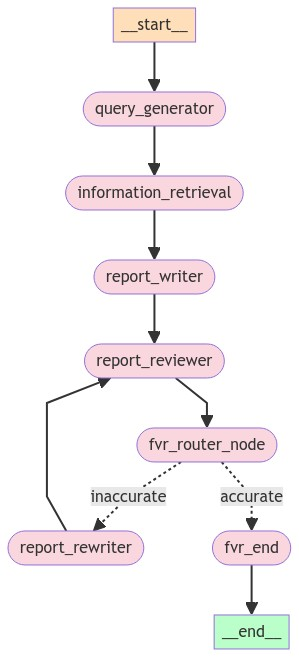

In [ ]:
# Define revision router node
def fvr_router_node(state: AgentState):
    if state["fvr_report_revision_count"] > 3:
        return "fvr_end"
    else:
        return state["fvr_review"]["decision"]

# Define nodes for the franchise viability risk team
fvr_state = StateGraph(AgentState)
fvr_state.add_node(node="query_generator", action=fvr_query_generator_node)
fvr_state.add_node(node="information_retrieval", action=fvr_hybrid_search_node)
fvr_state.add_node(node="report_writer", action=fvr_report_writer_node)
fvr_state.add_node(node="report_reviewer", action=fvr_report_reviewer_node)
fvr_state.add_node(node="report_rewriter", action=fvr_report_rewriter_node)
fvr_state.add_node(
    node="fvr_end",
    action=lambda state: {"final_report": state["content"]}
)

# Define edges for the franchise viability risk team
fvr_state.add_edge(start_key="query_generator", end_key="information_retrieval")
fvr_state.add_edge(start_key="information_retrieval", end_key="report_writer")
fvr_state.add_edge(start_key="report_writer", end_key="report_reviewer")
fvr_state.add_conditional_edges(
    source="report_reviewer",
    path=fvr_router_node,
    path_map={"inaccurate": "report_rewriter", "accurate": "fvr_end"}
)
fvr_state.add_edge(start_key="report_rewriter", end_key="report_reviewer")
fvr_state.set_entry_point("query_generator")
fvr_state.set_finish_point("fvr_end")

# Compile and visualise the franchise viability risk team state graph
app = fvr_state.compile()
Image(app.get_graph(xray=1).draw_mermaid_png())

### 3.3 Define nodes, edge connections, and graph for intraday liquidity risk team<a id="section-3-3"></a>

We replicate the workflow as defined in [section 3.1](#section-3-1), where the team undertakes the following tasks:
1. First, we utilise an LLM to generate a series of targetted topics related to the user's question to run our information retrieval pipeline.
2. We then run an ensemble retriever (semantic + lexical search) on the synthetic queries generated, which are then fed into an LLM contextual compressor to filter out irrelevant information.
3. Based on the retrieved information, we generate a concise report to answer the user's question.
4. A dedicated LLM agent will review the report against the retrieved information, to ensure factual accuracy and prevent model hallucination. If inaccuracies are detected, the agent will provide detailed comments on what those inaccuracies are.
5. A report rewriter will take into consideration both the original report and the reviewer agent's comments, and generate an amended report. This process of review-rewrite will repeat *n* times, defined by the state machine.

In [ ]:
def ilr_query_generator_node(state: AgentState):
    user_input = state["user_input"]
    prompt = f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|> \
    Based on the user's prompt about cashflow mismatch risk, extract the relevant \
    information to run a search. The extracted information can be structured as \
    keywords to search against or restructured queries. DO NOT change the underlying \
    meaning of the user's question. DO NOT miss out any abbreviations or acronyms, \
    be sure to include both the full term and the abbreviation in the query.

    For context, intraday liquidity risk involves the risks relating to payment \
    systems and securities settlement systems, covering both gross and net settlement. \
    It is the risk that a firm is unable to meet its daily settlement obligations, \
    for example, as a result of timing mismatches arising from direct and indirect \
    membership of relevant payments or securities settlements systems. Mitigating \
    the risk of double duty is a primary reason for including a calibration of \
    intraday liquidity risk in a firm's liquid asset buffer. Double duty refers \
    to the use of a liquid asset buffer held for wider liquidity resilience, to \
    also support payments and securities settlement activities intraday, where \
    intraday liquidity risk is not included as a risk in the calibration of the \
    liquid asset buffer. Conceptually, there is a significant risk associated with \
    using the same assets for two separate purposes: when the assets are used for \
    one purpose they are not available for another purpose. This can manifest as \
    balance sheet resilience risk and intraday liquidity risk.

    Return the decision in JSON format with the key being the name of the firm in \
    question e.g. 'Barclays' followed by the list of queries relevant to topic of \
    cashflow mismatch risk. The list of queries themselves do not need to repeat \
    the firm name. Each firm-query pair should be a dictionary. Limit your \
    queries to 3.
    <|eot_id|><|start_header_id|>user<|end_header_id|>
    QUERY: {user_input}
    <|eot_id|><|start_header_id|>assistant<|end_header_id|>"""
    ilr_retrieval_prompt = PromptTemplate(
        template=re.sub(" +", " ", prompt.strip()),
        input_variables=user_input
    )
    ilr_retrieval_router = ilr_retrieval_prompt | llm | JsonOutputParser()
    return {"ilr_queries": ilr_retrieval_router.invoke({"user_input": user_input})}


def ilr_hybrid_search_node(state: AgentState):
    retrieved_info = []
    for firm, queries in state["ilr_queries"].items():
        retrieved_info.append({firm: []})
        for retriever in retriever_db:
            for firm_name, retr in retriever.items():
                if firm == firm_name:
                    for query in tqdm(
                        iterable=queries,
                        desc=f"Retrieving information from {firm}",
                        unit="query",
                        total=len(queries)
                    ):
                        temp = retr.invoke(query)
                        compressed_context = ""
                        for i, doc in enumerate(temp, start=1):
                            compressed_context += f"Source {i}: " + doc.metadata["title"] + "\n"
                            compressed_context += "Page: " + str(doc.metadata["page"]) + "\n"
                            compressed_context += "Content: " + doc.page_content + "\n\n"
                        retrieved_info[-1][firm].append(compressed_context)
                else:
                    logging.error(f"Retriever for {firm} not found.")
                    continue

    return {"ilr_retrieved_info": retrieved_info}


def ilr_report_writer_node(state: AgentState):
    user_input = state["user_input"]
    retrieved_info = state["ilr_retrieved_info"]
    prompt = f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|> \
    Based on the user's prompt about cashflow mismatch risk and the retrieved \
    information, write a report that addresses the user's query. The report should \
    contain ONLY the relevant information extracted from the documents. DO NOT \
    include any additional information that is not directly related to the user's \
    query. The report should be concise and to the point. Always cite where the \
    information was extracted from, use the source name and page number.

    For context, intraday liquidity risk involves the risks relating to payment \
    systems and securities settlement systems, covering both gross and net settlement. \
    It is the risk that a firm is unable to meet its daily settlement obligations, \
    for example, as a result of timing mismatches arising from direct and indirect \
    membership of relevant payments or securities settlements systems. Mitigating \
    the risk of double duty is a primary reason for including a calibration of \
    intraday liquidity risk in a firm's liquid asset buffer. Double duty refers \
    to the use of a liquid asset buffer held for wider liquidity resilience, to \
    also support payments and securities settlement activities intraday, where \
    intraday liquidity risk is not included as a risk in the calibration of the \
    liquid asset buffer. Conceptually, there is a significant risk associated with \
    using the same assets for two separate purposes: when the assets are used for \
    one purpose they are not available for another purpose. This can manifest as \
    balance sheet resilience risk and intraday liquidity risk.
    <|eot_id|><|start_header_id|>user<|end_header_id|>
    QUERY: {user_input}
    CONTEXT: {retrieved_info}
    <|eot_id|><|start_header_id|>assistant<|end_header_id|>"""
    ilr_report_writer_prompt = PromptTemplate(
        template=re.sub(" +", " ", prompt.strip()),
        input_variables=[user_input, retrieved_info]
    )
    ilr_report_writer_router = ilr_report_writer_prompt | llm | StrOutputParser()
    return {
        "ilr_report": ilr_report_writer_router.invoke(
            {"user_input": user_input, "retrieved_info": retrieved_info}
        )
    }


def ilr_report_reviewer_node(state: AgentState):
    report = state["ilr_report"]
    retrieved_info = state["ilr_retrieved_info"]
    prompt = f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|> \
    Based on the report about cashflow mismatch risk and the retrieved \
    information, check if the report uses the correct information from the retrieved \
    documents. If the report is accurate, return 'accurate'. If the report is \
    inaccurate, return 'inaccurate'. If the report is inaccurate, provide a \
    thorough explanation of what is incorrect. Be specific about the inaccuracies, \
    listing the correct information that should have been included. DO NOT make \
    up any information that was not in the retrieved documents.

    For context, intraday liquidity risk involves the risks relating to payment \
    systems and securities settlement systems, covering both gross and net settlement. \
    It is the risk that a firm is unable to meet its daily settlement obligations, \
    for example, as a result of timing mismatches arising from direct and indirect \
    membership of relevant payments or securities settlements systems. Mitigating \
    the risk of double duty is a primary reason for including a calibration of \
    intraday liquidity risk in a firm's liquid asset buffer. Double duty refers \
    to the use of a liquid asset buffer held for wider liquidity resilience, to \
    also support payments and securities settlement activities intraday, where \
    intraday liquidity risk is not included as a risk in the calibration of the \
    liquid asset buffer. Conceptually, there is a significant risk associated with \
    using the same assets for two separate purposes: when the assets are used for \
    one purpose they are not available for another purpose. This can manifest as \
    balance sheet resilience risk and intraday liquidity risk.

    Return the decision in JSON format with the first JSON key being 'decision' \
    and values either 'accurate' or 'inaccurate', the second \
    JSON key being 'comments' and values being any explanations related to the \
    decision.
    <|eot_id|><|start_header_id|>user<|end_header_id|>
    REPORT: {report}
    CONTEXT: {retrieved_info}
    <|eot_id|><|start_header_id|>assistant<|end_header_id|>"""
    ilr_report_reviewer_prompt = PromptTemplate(
        template=re.sub(" +", " ", prompt.strip()),
        input_variables=[report, retrieved_info]
    )
    ilr_report_reviewer_router = ilr_report_reviewer_prompt | llm | JsonOutputParser()
    return {
        "ilr_review": ilr_report_reviewer_router.invoke(
            {"report": report, "retrieved_info": retrieved_info}
        )
    }

def ilr_report_rewriter_node(state: AgentState):
    user_input = state["user_input"]
    report = state["ilr_report"]
    retrieved_info = state["ilr_retrieved_info"]
    comments = review["ilr_review"]["comments"]
    prompt = f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|> \
    Based on the report written about {user_input}, the relevant information \
    retrieved, and the reviewer's comments about the report's accuracy, amend \
    the report by addressing those comments. provided write a report that addresses \
    the user's query. The report should contain ONLY the relevant information \
    extracted from the documents. DO NOT add any additional information that is \
    not relevant to the user's query. The report should be concise and to the point. \
    Always cite where the information was extracted from, use the source name and \
    page number.

    For context, intraday liquidity risk involves the risks relating to payment \
    systems and securities settlement systems, covering both gross and net settlement. \
    It is the risk that a firm is unable to meet its daily settlement obligations, \
    for example, as a result of timing mismatches arising from direct and indirect \
    membership of relevant payments or securities settlements systems. Mitigating \
    the risk of double duty is a primary reason for including a calibration of \
    intraday liquidity risk in a firm's liquid asset buffer. Double duty refers \
    to the use of a liquid asset buffer held for wider liquidity resilience, to \
    also support payments and securities settlement activities intraday, where \
    intraday liquidity risk is not included as a risk in the calibration of the \
    liquid asset buffer. Conceptually, there is a significant risk associated with \
    using the same assets for two separate purposes: when the assets are used for \
    one purpose they are not available for another purpose. This can manifest as \
    balance sheet resilience risk and intraday liquidity risk.
    <|eot_id|><|start_header_id|>user<|end_header_id|>
    REPORT: {report}
    CONTEXT: {retrieved_info}
    COMMENTS: {comments}
    <|eot_id|><|start_header_id|>assistant<|end_header_id>"""
    ilr_report_writer_prompt = PromptTemplate(
        template=re.sub(" +", " ", prompt.strip()),
        input_variables=[user_input, report, retrieved_info, comments]
    )
    ilr_report_writer_router = ilr_report_writer_prompt | llm | StrOutputParser()
    return {
        "ilr_report": ilr_report_writer_router.invoke(
            {
                "user_input": user_input,
                "report": report,
                "user_input": retrieved_info,
                "comments": comments
            }
        ),
        "ilr_revision_count": state["ilr_revision_count"] + 1
    }

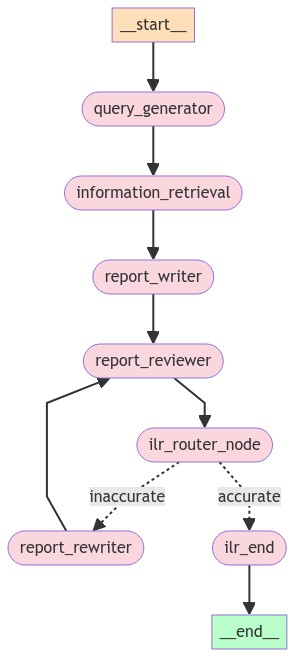

In [ ]:
# Define revision router node
def ilr_router_node(state: AgentState):
    if state["ilr_report_revision_count"] > 3:
        return "ilr_end"
    else:
        return state["ilr_review"]["decision"]

# Define nodes for the intraday liquidity risk team
ilr_state = StateGraph(AgentState)
ilr_state.add_node(node="query_generator", action=ilr_query_generator_node)
ilr_state.add_node(node="information_retrieval", action=ilr_hybrid_search_node)
ilr_state.add_node(node="report_writer", action=ilr_report_writer_node)
ilr_state.add_node(node="report_reviewer", action=ilr_report_reviewer_node)
ilr_state.add_node(node="report_rewriter", action=ilr_report_rewriter_node)
ilr_state.add_node(
    node="ilr_end",
    action=lambda state: {"final_report": state["content"]}
)

# Define edges for the intraday liquidity risk team
ilr_state.add_edge(start_key="query_generator", end_key="information_retrieval")
ilr_state.add_edge(start_key="information_retrieval", end_key="report_writer")
ilr_state.add_edge(start_key="report_writer", end_key="report_reviewer")
ilr_state.add_conditional_edges(
    source="report_reviewer",
    path=ilr_router_node,
    path_map={"inaccurate": "report_rewriter", "accurate": "ilr_end"}
)
ilr_state.add_edge(start_key="report_rewriter", end_key="report_reviewer")
ilr_state.set_entry_point("query_generator")
ilr_state.set_finish_point("ilr_end")

# Compile and visualise the intraday liquidity risk team state graph
app = ilr_state.compile()
Image(app.get_graph(xray=1).draw_mermaid_png())

---

## 4. Define inter-agent team edges and graph<a id="section-4"></a>

With the sub-team graphs defined, we integrated all the specialist sub-teams into a unified liquidity risk management team.

### 4.1 Simplified overview of the graph<a id="section-4-1"></a>

In [ ]:
def orchestrator_node(state: AgentState):
    user_input = state["user_input"]
    prompt = f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|> \
    You are the lead delegator for a team of liquidity risk specialists. The team \
    of risk specialists are 'cashflow_mismatch_risk', 'franchise_viability_risk', \
    'intraday_liquidity_risk', 'credit_risk', and 'operational_risk'. Your job is to understand \
    the user's query and decide which downstream agents should work on the query.

    Use the following criteria to decide how to route the query:
    - Cashflow mismatch risk revolves around the risk that a firm has insufficient \
       liquidity from high quality liquid assets (HQLA) and other liquidity inflows \
        to cover liquidity outflows on a daily basis, e.g. measure of a firm's \
        cumulative liquidity position at the end of a 30 day period, i.e. \
        liquidity coverage ratio (LCR). These risks should be directed to \
        'cashflow_mismatch_risk'.
    - Franchise viability risk includes risks from firms' actions that cause unforeseen \
        liquidity outflows, debt buyback risk, the risk of early termination of \
        non-margined derivatives, and prime brokerage and matched book liquidity \
        risks. These risks should be directed to 'franchise_viability_risk'.
    - Intraday liquidity risk involves the risks relating to payment systems and \
        securities settlement systems, covering both gross and net settlement. \
        These risks should be directed to 'intraday_liquidity_risk'.

    Return the decision in JSON format with the key 'decision' and the list of \
    corresponding teams that should be directed (empty list of there are no relevant teams).
    <|eot_id|><|start_header_id|>user<|end_header_id|>
    QUERY: {user_input}
    <|eot_id|><|start_header_id|>assistant<|end_header_id|>"""
    orchestrator_agent_prompt = PromptTemplate(
        template=re.sub(" +", " ", prompt.strip()),
        input_variables=user_input
    )
    orchestrator_router = orchestrator_agent_prompt | llm | JsonOutputParser()
    teams_activated = orchestrator_router.invoke({"user_input": user_input})
    return {"teams_activated": teams_activated["decision"], "teams_completed": []}


def router_node(state: AgentState):
    if state["teams_activated"] == []:
        return "report_compiler"
    else:
        team = state["teams_activated"][0]
        state["teams_completed"].append(team)
        state["teams_activated"].pop(0)
        return team


def cashflow_mismatch_risk_node(state: AgentState):
    prompt = "This is a placeholder for the cashflow mismatch risk nodes"
    cashflow_mismatch_risk_prompt = PromptTemplate(
        template=re.sub(" +", " ", prompt.strip())
    )
    cashflow_mismatch_risk_router = cashflow_mismatch_risk_prompt | llm | StrOutputParser()
    content = AIMessage(content=cashflow_mismatch_risk_router.invoke({}))
    return {"content": [content]}


def franchise_viability_risk_node(state: AgentState):
    prompt = "This is a placeholder for the franchise viability risk nodes"
    franchise_viability_risk_prompt = PromptTemplate(
        template=re.sub(" +", " ", prompt.strip())
    )
    franchise_viability_risk_router = franchise_viability_risk_prompt | llm | StrOutputParser()
    content = AIMessage(content=franchise_viability_risk_router.invoke({}))
    return {"content": [content]}


def intraday_liquidity_risk_node(state: AgentState):
    prompt = "This is a placeholder for the intraday liquidity risk nodes"
    intraday_liquidity_risk_prompt = PromptTemplate(
        template=re.sub(" +", " ", prompt.strip())
    )
    intraday_liquidity_risk_router = intraday_liquidity_risk_prompt | llm | StrOutputParser()
    content = intraday_liquidity_risk_router.invoke({})
    return {"content": [content]}


def report_compiler_node(state: AgentState):
    return {"final_report": state["cfmr_report"] + state["fvr_report"] + state["ilr_report"]}

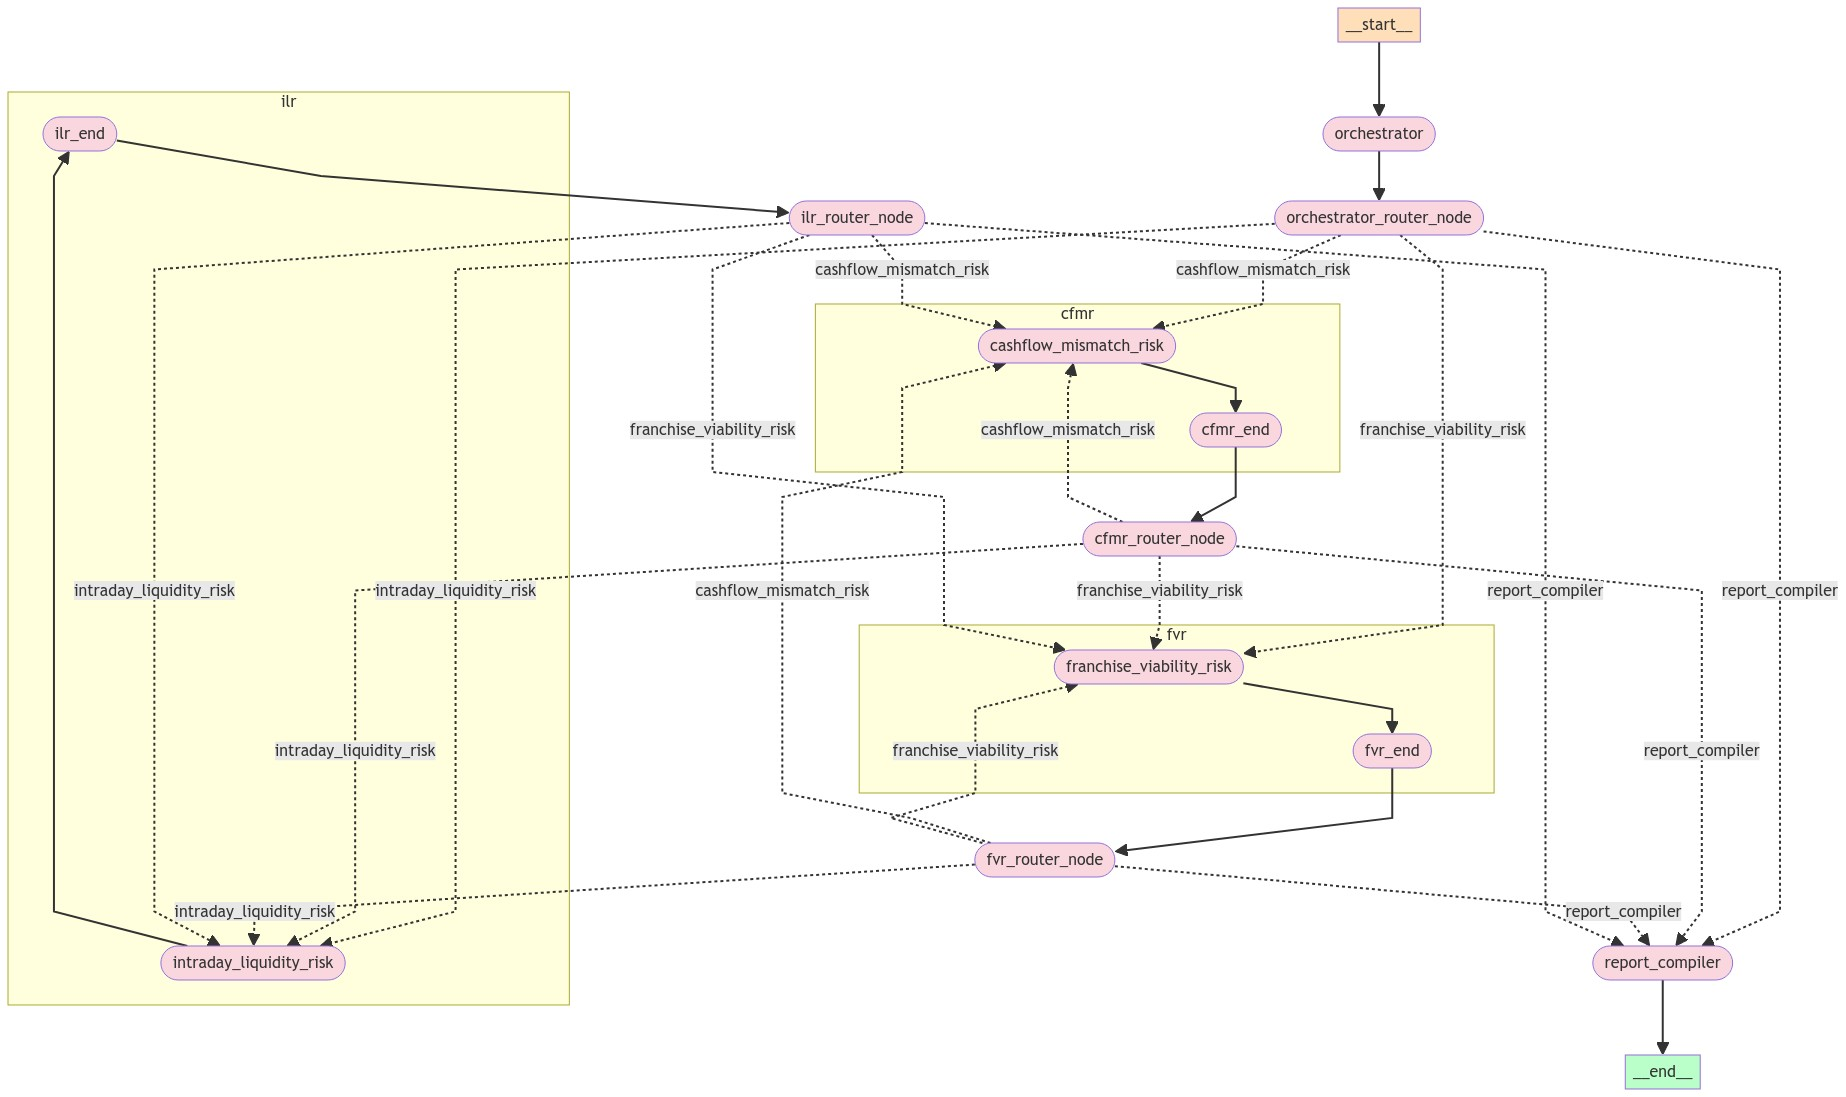

In [ ]:
# Define the mapping for the team router
team_map = {
    "cashflow_mismatch_risk": "cfmr",
    "franchise_viability_risk": "fvr",
    "intraday_liquidity_risk": "ilr",
    "report_compiler": "report_compiler"
}

# Define the state graph for the cashflow mismatch risk sub-team
cfmr_state = StateGraph(AgentState)
cfmr_state.add_node(node="cashflow_mismatch_risk", action=cashflow_mismatch_risk_node)
cfmr_state.add_node(
    node="cfmr_end",
    action=lambda state: {"final_report": state["content"]}
)
cfmr_state.add_edge(start_key="cashflow_mismatch_risk", end_key="cfmr_end")
cfmr_state.set_entry_point("cashflow_mismatch_risk")
cfmr_state.set_finish_point("cfmr_end")

# Define the state graph for the franchise viability risk sub-team
fvr_state = StateGraph(AgentState)
fvr_state.add_node(node="franchise_viability_risk", action=franchise_viability_risk_node)
fvr_state.add_node(
    node="fvr_end",
    action=lambda state: {"final_report": state["content"]}
)
fvr_state.add_edge(start_key="franchise_viability_risk", end_key="fvr_end")
fvr_state.set_entry_point("franchise_viability_risk")
fvr_state.set_finish_point("fvr_end")

# Define the state graph for the intraday liquidity risk sub-team
ilr_state = StateGraph(AgentState)
ilr_state.add_node(node="intraday_liquidity_risk", action=intraday_liquidity_risk_node)
ilr_state.add_node(
    node="ilr_end",
    action=lambda state: {"final_report": state["content"]}
)
ilr_state.add_edge(start_key="intraday_liquidity_risk", end_key="ilr_end")
ilr_state.set_entry_point("intraday_liquidity_risk")
ilr_state.set_finish_point("ilr_end")

# Define the state graph for the simplified liquidity risk management team
team_state = StateGraph(AgentState)
team_state.add_node(node="orchestrator", action=orchestrator_node)
team_state.set_entry_point("orchestrator")
team_state.add_node(node="cfmr", action=cfmr_state.compile())
team_state.add_node(node="fvr", action=fvr_state.compile())
team_state.add_node(node="ilr", action=ilr_state.compile())
team_state.add_node(node="report_compiler", action=report_compiler_node)
team_state.add_conditional_edges(
    source="orchestrator",
    path=router_node,
    path_map=team_map
)
team_state.add_conditional_edges(
    source="cfmr",
    path=router_node,
    path_map=team_map
)
team_state.add_conditional_edges(
    source="fvr",
    path=router_node,
    path_map=team_map
)
team_state.add_conditional_edges(
    source="ilr",
    path=router_node,
    path_map=team_map
)
team_state.add_edge(start_key="report_compiler", end_key=END)

# Compile and visualise the simplified liquidity risk management team state graph
app = team_state.compile()
Image(app.get_graph(xray=1).draw_mermaid_png())

### 4.2 Complete overview of the graph<a id="section-4-2"></a>

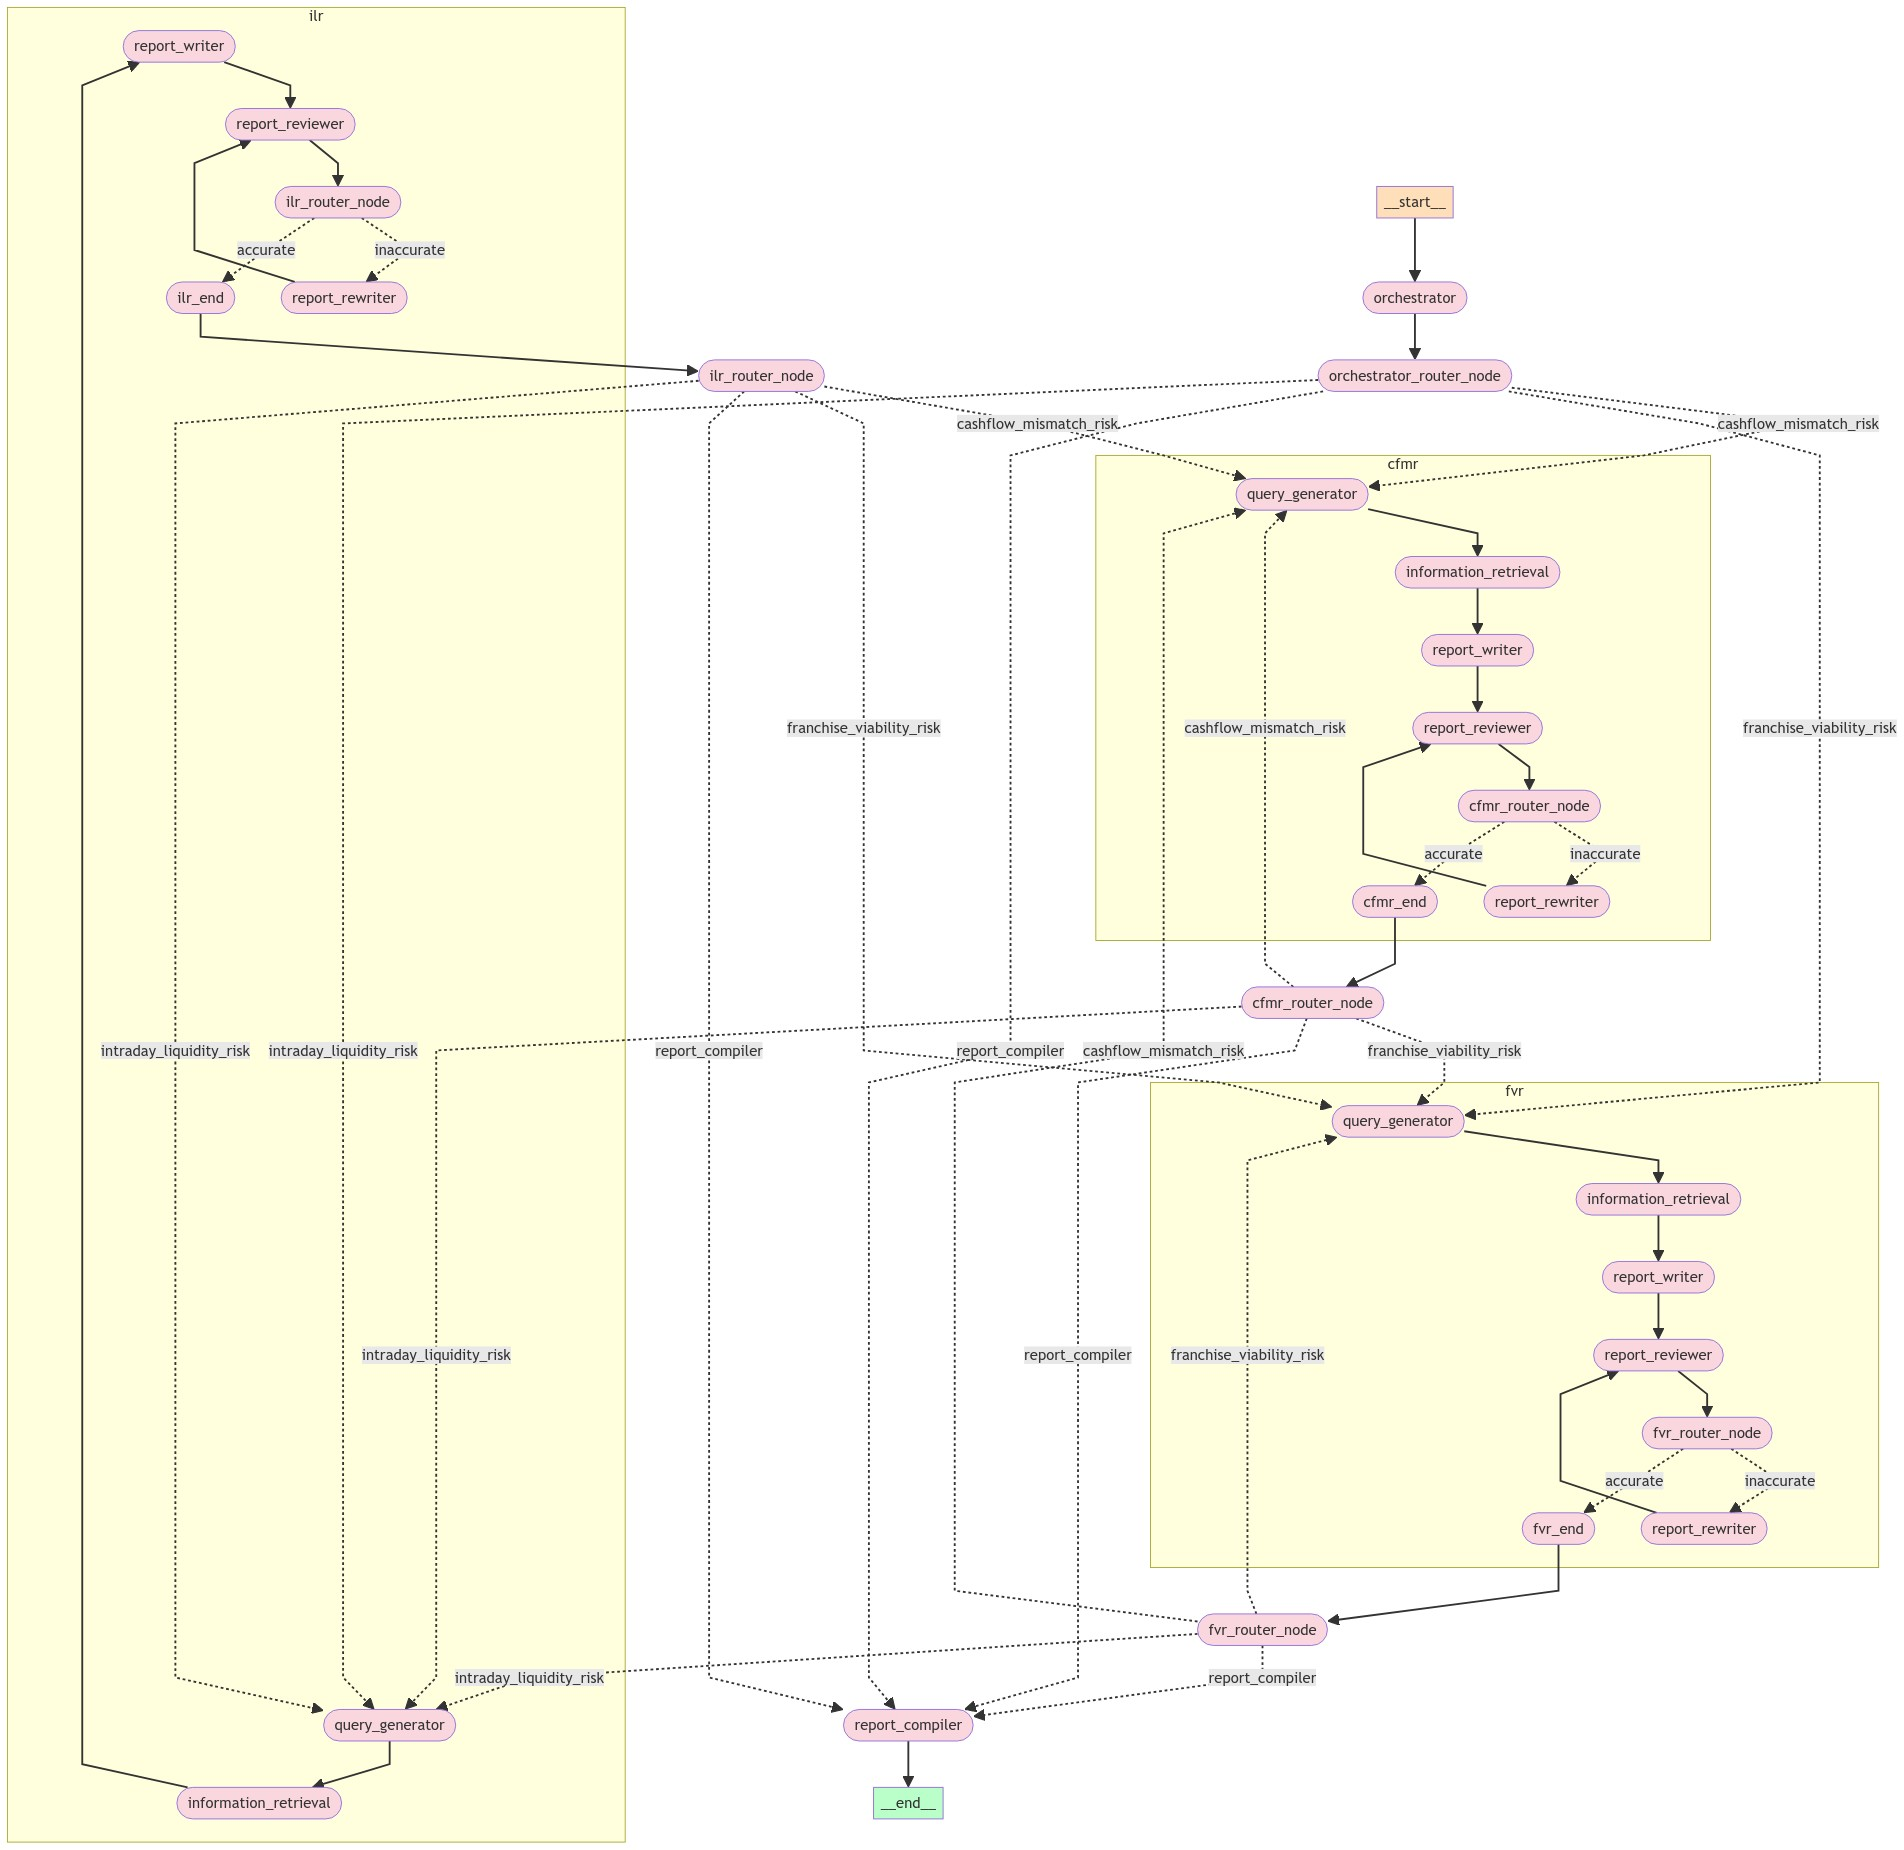

In [ ]:
# Define the mapping for the team router
team_map = {
    "cashflow_mismatch_risk": "cfmr",
    "franchise_viability_risk": "fvr",
    "intraday_liquidity_risk": "ilr",
    "report_compiler": "report_compiler"
}

# Define the state graph for the cashflow mismatch risk sub-team
cfmr_state = StateGraph(AgentState)
cfmr_state.add_node(node="query_generator", action=cfmr_query_generator_node)
cfmr_state.add_node(node="information_retrieval", action=cfmr_hybrid_search_node)
cfmr_state.add_node(node="report_writer", action=cfmr_report_writer_node)
cfmr_state.add_node(node="report_reviewer", action=cfmr_report_reviewer_node)
cfmr_state.add_node(node="report_rewriter", action=cfmr_report_rewriter_node)
cfmr_state.add_node(
    node="cfmr_end",
    action=lambda state: {"final_report": state["content"]}
)

# Define edges for the cashflow mismatch risk team
cfmr_state.add_edge(start_key="query_generator", end_key="information_retrieval")
cfmr_state.add_edge(start_key="information_retrieval", end_key="report_writer")
cfmr_state.add_edge(start_key="report_writer", end_key="report_reviewer")
cfmr_state.add_conditional_edges(
    source="report_reviewer",
    path=cfmr_router_node,
    path_map={"inaccurate": "report_rewriter", "accurate": "cfmr_end"}
)
cfmr_state.add_edge(start_key="report_rewriter", end_key="report_reviewer")
cfmr_state.set_entry_point("query_generator")
cfmr_state.set_finish_point("cfmr_end")

# Define the state graph for the franchise viability risk sub-team
fvr_state = StateGraph(AgentState)
fvr_state.add_node(node="query_generator", action=fvr_query_generator_node)
fvr_state.add_node(node="information_retrieval", action=fvr_hybrid_search_node)
fvr_state.add_node(node="report_writer", action=fvr_report_writer_node)
fvr_state.add_node(node="report_reviewer", action=fvr_report_reviewer_node)
fvr_state.add_node(node="report_rewriter", action=fvr_report_rewriter_node)
fvr_state.add_node(
    node="fvr_end",
    action=lambda state: {"final_report": state["content"]}
)

# Define edges for the franchise viability risk team
fvr_state.add_edge(start_key="query_generator", end_key="information_retrieval")
fvr_state.add_edge(start_key="information_retrieval", end_key="report_writer")
fvr_state.add_edge(start_key="report_writer", end_key="report_reviewer")
fvr_state.add_conditional_edges(
    source="report_reviewer",
    path=fvr_router_node,
    path_map={"inaccurate": "report_rewriter", "accurate": "fvr_end"}
)
fvr_state.add_edge(start_key="report_rewriter", end_key="report_reviewer")
fvr_state.set_entry_point("query_generator")
fvr_state.set_finish_point("fvr_end")

# Define the state graph for the intraday liquidity risk sub-team
ilr_state = StateGraph(AgentState)
ilr_state.add_node(node="query_generator", action=ilr_query_generator_node)
ilr_state.add_node(node="information_retrieval", action=ilr_hybrid_search_node)
ilr_state.add_node(node="report_writer", action=ilr_report_writer_node)
ilr_state.add_node(node="report_reviewer", action=ilr_report_reviewer_node)
ilr_state.add_node(node="report_rewriter", action=ilr_report_rewriter_node)
ilr_state.add_node(
    node="ilr_end",
    action=lambda state: {"final_report": state["content"]}
)

# Define edges for the intraday liquidity risk team
ilr_state.add_edge(start_key="query_generator", end_key="information_retrieval")
ilr_state.add_edge(start_key="information_retrieval", end_key="report_writer")
ilr_state.add_edge(start_key="report_writer", end_key="report_reviewer")
ilr_state.add_conditional_edges(
    source="report_reviewer",
    path=ilr_router_node,
    path_map={"inaccurate": "report_rewriter", "accurate": "ilr_end"}
)
ilr_state.add_edge(start_key="report_rewriter", end_key="report_reviewer")
ilr_state.set_entry_point("query_generator")
ilr_state.set_finish_point("ilr_end")

# Define the state graph for the unified liquidity risk management team
team_state = StateGraph(AgentState)
team_state.add_node(node="orchestrator", action=orchestrator_node)
team_state.set_entry_point("orchestrator")
team_state.add_node(node="cfmr", action=cfmr_state.compile())
team_state.add_node(node="fvr", action=fvr_state.compile())
team_state.add_node(node="ilr", action=ilr_state.compile())
team_state.add_node(node="report_compiler", action=report_compiler_node)
team_state.add_conditional_edges(
    source="orchestrator",
    path=router_node,
    path_map=team_map
)
team_state.add_conditional_edges(
    source="cfmr",
    path=router_node,
    path_map=team_map
)
team_state.add_conditional_edges(
    source="fvr",
    path=router_node,
    path_map=team_map
)
team_state.add_conditional_edges(
    source="ilr",
    path=router_node,
    path_map=team_map
)
team_state.add_edge(start_key="report_compiler", end_key=END)

# Compile and visualise the unified liquidity risk management team state graph
app = team_state.compile()
Image(app.get_graph(xray=1).draw_mermaid_png())